In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from sklearn.metrics import roc_auc_score

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [2]:
import torch
import numpy as np

DOUBLE_INFO = torch.finfo(torch.double)
JITTERS = [0, DOUBLE_INFO.tiny] + [10 ** exp for exp in range(-10, 0, 1)]


def centered_cov(x):
    return x.T @ x / (len(x) - 1)


def compute_density(log_logits, label_probs):
    return torch.logsumexp(log_logits, dim=-1)
    #return torch.sum((torch.exp(log_logits) * label_probs), dim=1)


def get_gmm_log_probs(gaussians_model, embeddings):
    return gaussians_model.log_prob(embeddings[:, None, :])


def gmm_fit(embeddings, labels):
    num_classes = len(set(labels))
    with torch.no_grad():
        centroids = torch.stack(
            [torch.mean(embeddings[labels == c], dim=0) for c in range(num_classes)]
        )
        cov_matrix = torch.stack(
            [
                centered_cov(embeddings[labels == c] - centroids[c])
                for c in range(num_classes)
            ]
        )

    with torch.no_grad():
        for jitter_eps in JITTERS:
            try:
                jitter = jitter_eps * torch.eye(
                    cov_matrix.shape[1], device=cov_matrix.device,
                ).unsqueeze(0)
                gmm = torch.distributions.MultivariateNormal(
                    loc=centroids, covariance_matrix=(cov_matrix + jitter),
                )
                break
            except RuntimeError as e:
                if "cholesky" in str(e):
                    continue
            except ValueError as e:
                if "The parameter covariance_matrix has invalid values" in str(e):
                    continue
    return gmm, jitter_eps

In [3]:
import matplotlib
from sklearn import datasets
from sklearn.model_selection import train_test_split

plt.rcParams.update({"font.size": 16})

def plot_data(X, y, title=None):
    plt.close()
    plt.figure()
    if title:
        plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.tight_layout()
    plt.show()


def make_data(total_size=5000, centers=np.array([[-4.0, -4.0], [0.0, 4.0]]), seed=42):
    X, y = datasets.make_moons(n_samples=total_size, shuffle=True, noise=0.1, random_state=seed)
    return X, y

In [4]:
import sys
sys.path.insert(0,'..')

from ue4nlp.mahalanobis_distance import (
    mahalanobis_distance,
    mahalanobis_distance_relative,
    mahalanobis_distance_marginal,
    compute_centroids,
    compute_covariance
)

# Strong NN Model

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [6]:
def make_data(total_size=5000, centers=np.array([[-4.0, -4.0], [0.0, 4.0]]), seed=42, noise=0.1):
    X, y = datasets.make_moons(n_samples=total_size, shuffle=True, noise=noise, random_state=seed)
    return X, y

In [7]:
from scipy.stats import rankdata
from sklearn.preprocessing import KBinsDiscretizer

def total_uncertainty_linear_step(aleatoric, epistemic, threshold_min=0.1, threshold_max=0.9, alpha=0.5):
    n_preds = len(aleatoric)
    n_lowest = int(n_preds*threshold_min)
    n_max = int(n_preds*threshold_max)
    
    aleatoric_rank = rankdata(aleatoric)
    epistemic_rank = rankdata(epistemic)

    total_rank = np.zeros_like(epistemic)
    
    total_rank = (1-alpha)*epistemic_rank+alpha*aleatoric_rank
    total_rank[epistemic_rank <= n_lowest] = rankdata(aleatoric[epistemic_rank <= n_lowest])
    total_rank[aleatoric_rank > n_max] = aleatoric_rank[aleatoric_rank > n_max]

    return total_rank

In [9]:
class FCResNet(torch.nn.Module):
    def __init__(
        self,
        input_dim=2,
        features=128,
        depth=4,
        spectral_normalization=True,
        coeff=0.95,
        n_power_iterations=1,
        activation='relu',
        dropout_rate=0.01
    ):
        super().__init__()

        self.first = torch.nn.Linear(input_dim, features)
        self.residuals = torch.nn.ModuleList(
            [torch.nn.Linear(features, features) for i in range(depth)]
        )
        self.dropout = torch.nn.Dropout(dropout_rate)

        if spectral_normalization:
            self.first = torch.nn.utils.spectral_norm(
                self.first, n_power_iterations=n_power_iterations
            )

            for i in range(len(self.residuals)):
                self.residuals[i] = torch.nn.utils.spectral_norm(
                    self.residuals[i],
                    n_power_iterations=n_power_iterations,
                )
        self.last = torch.nn.Linear(features, 2)

        self.activation = torch.nn.ReLU()


    def forward(self, x):
        x = self.first(x)
        for residual in self.residuals:
            x = x + self.dropout(self.activation(residual(x)))
        self.feature = x
        x = self.last(x)
        return x

In [11]:
from torch.utils.data import TensorDataset, DataLoader
def fit_model(model, train_dataloader, criterion, optimizer):
    model.train()
    epoch = 150
    for epoch in range(epoch):
        for it, (X_batch, y_batch) in enumerate(train_dataloader):
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            loss.backward()
            optimizer.step()
        if (epoch+1)%10 == 0:
            print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    model.eval()
    return model

In [13]:
from sklearn.decomposition import KernelPCA
from sklearn.covariance import MinCovDet

(5612, 2)
Epoch 9: train loss: 0.22322309017181396
Epoch 19: train loss: 0.10031089931726456
Epoch 29: train loss: 0.03695911541581154
Epoch 39: train loss: 0.02076307125389576
Epoch 49: train loss: 0.016604341566562653
Epoch 59: train loss: 0.01490984670817852
Epoch 69: train loss: 0.008627336472272873
Epoch 79: train loss: 0.0075165024027228355
Epoch 89: train loss: 0.006749360356479883
Epoch 99: train loss: 0.004735990893095732
Epoch 109: train loss: 0.004379044286906719
Epoch 119: train loss: 0.004738396964967251
Epoch 129: train loss: 0.0026056973729282618
Epoch 139: train loss: 0.0031095065642148256
Epoch 149: train loss: 0.0022218532394617796


2it [00:00, 18.93it/s]
/home/user/conda/envs/ue/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/user/conda/envs/ue/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


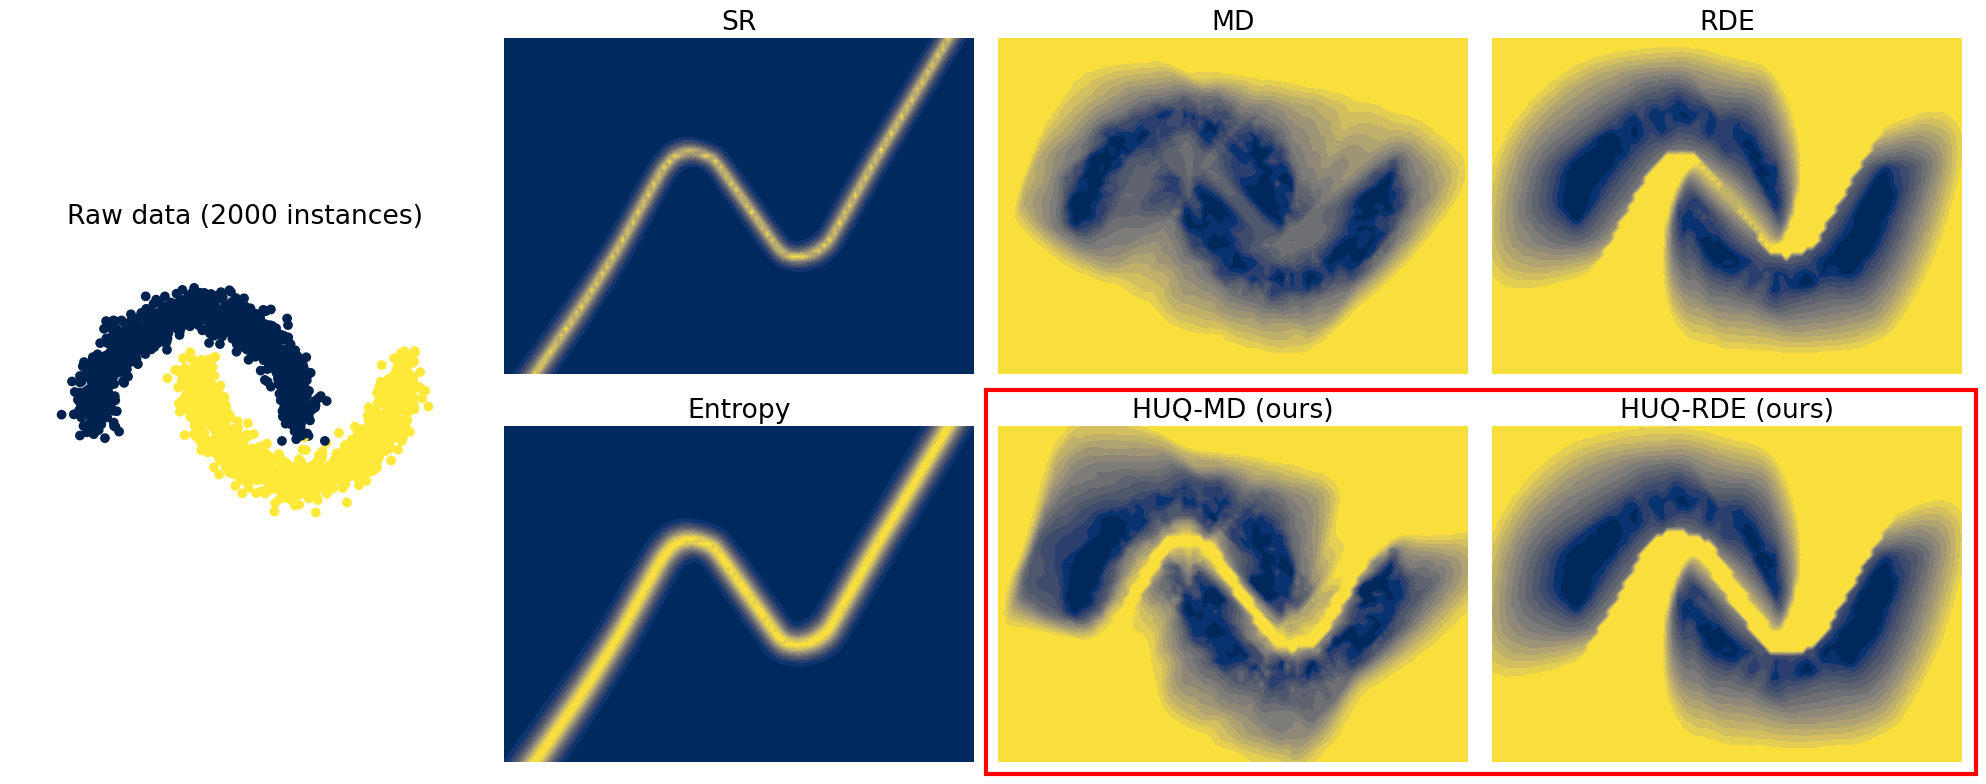

In [14]:
from sklearn.preprocessing import KBinsDiscretizer
from scipy.special import softmax
from matplotlib import gridspec

def entropy(x):
    return np.sum(-x * np.log(np.clip(x, 1e-8, 1)), axis=-1)

sizes = [2_000]
#fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 8), sharey=True)
#ax = ax.ravel()

plt.rcParams.update({"font.size": 16})
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(4, 8)

seed_everything(0)
cmap = 'cividis'

results = {}

model_type = 'sn'
for k, size in enumerate(sizes):
    
    X_train, y_train = make_data(
        total_size=size, seed=1
    )
    x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
    y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5

    h_x, h_y = [0.05] * 2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x), np.arange(y_min, y_max, h_y))
    X_test = np.c_[xx.ravel(), yy.ravel()]
    print(f"{X_test.shape}")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_train_torch = torch.Tensor(X_train).to(device)
    X_test_torch = torch.Tensor(X_test).to(device)
    
    y_train_torch = torch.Tensor(y_train).to(device)
    y_train_torch = y_train_torch.long()#torch.nn.functional.one_hot(y_train_torch.long()).float()
    
    if model_type == 'sn':
        model = FCResNet().to(device)#
    else:
        model = MLP().to(device)
        
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    train_dataset = TensorDataset(X_train_torch, y_train_torch)
    train_dataloader = DataLoader(train_dataset, batch_size=128)
    
    model = fit_model(model, train_dataloader, criterion, optimizer)
    if model_type == 'sn':
        train_preds = model(X_train_torch)
        train_features = model.feature
        preds = model(X_test_torch)
        features = model.feature
    
        
    else:
        X_val_torch = torch.Tensor(X_val).to(device)
        train_preds, train_features = model(X_train_torch, return_hiddens=True)
        preds, features = model(X_test_torch, return_hiddens=True)
        val_preds, val_features = model(X_val_torch, return_hiddens=True)

    train_features_np = train_features.detach().cpu().numpy()
    features_np = features.detach().cpu().numpy()

    ax1 = plt.subplot(gs[1:3, :2])
    ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    ax1.axis('off')
    ax1.set_title(f"Raw data (2000 instances)")
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    
    
    X_test_torch = torch.Tensor(X_test).to(device)
    logits_nn = model(X_test_torch).detach().cpu().numpy()
    probs_nn = softmax(logits_nn, axis=-1)

    ax2 = plt.subplot(gs[:2, 2:4])
    ax2.set_title(f"SR")
    ax2.contourf(xx, yy, -np.max(probs_nn, axis=-1).reshape(*xx.shape), levels=15, cmap=cmap)
    ax2.axis('off')
    
    md, _ = mahalanobis_distance(train_features_np, y_train, features_np, None, None)
    kb = KBinsDiscretizer(n_bins=100, encode='ordinal')
    res = kb.fit_transform(md.reshape(-1, 1))
    res = np.clip(res, -1, 60)

    ax3 = plt.subplot(gs[:2, 4:6])
    ax3.set_title(f"MD")
    ax3.contourf(xx, yy, res.reshape(*xx.shape), levels=15, cmap=cmap)
    ax3.axis('off')

    pca = KernelPCA(n_components=100, kernel='rbf', random_state=0)
    train_features_np_pca = pca.fit_transform(train_features_np)
    features_np_pca = pca.transform(features_np)
    
    covariances = [MinCovDet(random_state=0).fit(train_features_np_pca[y_train==label]) for label in np.unique(y_train)]
    #rde = np.array([cov.mahalanobis(features_np_pca) for cov in covariances]).T.min(-1)
    all_dists = np.array([cov.mahalanobis(features_np_pca) for cov in covariances]).T
    rde = np.array([dist_i[pred_i] for pred_i, dist_i in zip(preds.detach().cpu().numpy().argmax(-1), all_dists)])
    kb = KBinsDiscretizer(n_bins=100, encode='ordinal')
    res = kb.fit_transform(rde.reshape(-1, 1))
    res = np.clip(res, -1, 60)

    ax4 = plt.subplot(gs[:2, 6:8])
    ax4.set_title(f"RDE")
    ax4.contourf(xx, yy, res.reshape(*xx.shape), levels=15, cmap=cmap)
    ax4.axis('off')


X_test_torch = torch.Tensor(X_test).to(device)
logits_nn = model(X_test_torch).detach().cpu().numpy()
probs_nn = softmax(logits_nn, axis=-1)
ent = entropy(probs_nn)

for k, size in enumerate(sizes):
    idx = (k+1)*4
    
    ax5 = plt.subplot(gs[2:, 2:4])
    ax5.set_title(f"Entropy")
    ax5.contourf(xx, yy, ent.reshape(*xx.shape), levels=15, cmap=cmap)
    ax5.axis('off')

    res_md = total_uncertainty_linear_step(ent, md, 0.03, 0.95, 0.35)
    res_md = kb.fit_transform(res_md.reshape(-1, 1))
    res_md = np.clip(res_md, -1, 60).flatten()
    
    ax6 = plt.subplot(gs[2:, 4:6])
    ax6.set_title(f"HUQ-MD (ours)")
    ax6.contourf(xx, yy, res_md.reshape(*xx.shape), levels=15, cmap=cmap)
    ax6.axis('off')

    res_rde = total_uncertainty_linear_step(ent, rde, 0.05, 0.92, 0.1)
    res_rde = kb.fit_transform(res_rde.reshape(-1, 1))
    res_rde = np.clip(res_rde, -1, 60).flatten()

    ax6 = plt.subplot(gs[2:, 6:8])
    ax6.set_title(f"HUQ-RDE (ours)")
    ax6.contourf(xx, yy, res_rde.reshape(*xx.shape), levels=15, cmap=cmap)
    ax6.axis('off')

    
rect = plt.Rectangle(
    (0.5, 0.015), 0.495, 0.48, fill=False, color="r", lw=3, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])
    
plt.tight_layout()
#fig.savefig("../../workdir/images/two_moons_hybrid_ue_huq.pdf")
#fig.savefig("../../workdir/images/two_moons_hybrid_ue_huq.svg")
#fig.savefig("../../workdir/images/two_moons_hybrid_ue_huq.png")
plt.show()